# EpochAI BD of Internal Benchmarks

## Load benchmarks

In [22]:
import os
os.environ['AIRTABLE_PERSONAL_ACCESS_TOKEN'] = 'patmLNrsw9vgXl4la.4deb7e597571198c6bce5e65fc3c5abf0b0adbef0c6f9d9d9ea1320506ed477f'
os.environ['AIRTABLE_BASE_ID'] = 'appyrAKkx5f7xSVgl' # Internal EpochAI BD

In [23]:
from epochai.airtable.models import MLModel, Task, Score, Organization, BenchmarkRun

# Get everything at the start to minimize API calls
scores = Score.all(memoize=True)
runs = BenchmarkRun.all(memoize=True)
models = MLModel.all(memoize=True)
tasks = Task.all(memoize=True)
organizations = Organization.all(memoize=True)

In [ ]:
# Code modified from https://github.com/epoch-research/epochai-python/examples/airtable.py

#with open("/Users/jeremyandreolettigpaipolicylab/Documents/Recherche/Model_Benchmark_forecasting/epochai-python/examples/airtable.py") as f:
#    code = f.read()
#    exec(code)

from rich.console import Console
from rich.table import Table
import logging

console = Console()

# Define consistent colors for different types of objects
COLORS = {
    "MODEL": "blue",
    "ORG": "yellow",
    "TASK": "magenta",
    "SCORE": "green",
    "ERROR": "red",
    "DEVELOPER": "cyan",
    "DATE": "grey70",
    "ACCESSIBILITY": "orange",
    "COMPUTE": "purple",
}

def print_high_scores(task_path: str, scorer: str, scores: list[Score]):
    task = Task.first(formula=f"path='{task_path}'")
    if not task:
        raise ValueError(f"Task {task_path} not found")
        
    # Get all scores for the task and scorer
    task_scores = []
    for score in scores:
        try:
            # Access score attributes directly
            if score.benchmark_run is None:
                continue
                
            run = score.benchmark_run
            
            # Check if this matches our criteria
            if run.task and run.task.path == task_path and score.scorer == scorer:
                task_scores.append({
                    'score': score,
                    'run': run,
                    'mean': float(score.mean if score.mean is not None else 0),
                    'stderr': float(score.stderr if score.stderr is not None else 0)
                })
        except Exception as e:
            logging.debug(f"Skipped score: {e}")
            continue
    
    # Sort by mean score in descending order and take top 10
    top_scores = sorted(task_scores, key=lambda x: x['mean'], reverse=True)[:10]

    # Create a rich table for top scores
    table = Table(title=f"\nTop 10 Scores for {task_path} ({scorer})", 
                 show_header=True,
                 header_style="bold")
    table.add_column("Model ID", style=COLORS['MODEL'])
    table.add_column("Release Date", style=COLORS['DATE'])
    table.add_column("Est. Training Compute", style=COLORS['COMPUTE'])
    table.add_column("Score", justify="right", style=COLORS['SCORE'])
    table.add_column("Std Error", justify="right", style=COLORS['ERROR'])

    for score_data in top_scores:
        run = score_data['run']
        model = run.model
        
        # Use direct attributes for model
        release_date = model.release_date if model.release_date else 'N/A'
        model_name = model.model_id if model.model_id else 'Unknown'
        
        # Get training compute from model_group
        compute = 'N/A'
        if model.model_group and hasattr(model.model_group, 'training_compute'):
            compute = model.model_group.training_compute
        
        # Format compute in scientific notation if it's a number
        if compute != 'N/A' and compute is not None:
            try:
                compute = f"{float(compute):.2e}"
            except:
                compute = 'N/A'
        
        table.add_row(
            model_name,
            str(release_date),
            str(compute),
            f"{score_data['mean']:.3f}",
            f"{score_data['stderr']:.3f}"
        )

    console.print(table)
    print(f"\nFound {len(task_scores)} total scores, showing top {len(top_scores)}")

def print_performance_timeline(task_path: str, scorer: str, scores: list[Score], start_date=None,
                             end_date=None):
    """Show how the best performance on a task evolved over time."""
    # Get all scores for the task and scorer
    task_scores = []
    for score in scores:
        try:
            if score.benchmark_run is None:
                continue
            run = score.benchmark_run
            if run.task and run.task.path == task_path and score.scorer == scorer:
                task_scores.append(score)
        except Exception:
            continue

    if not task_scores:
        console.print(f"[{COLORS['ERROR']}]No scores found for {task_path} with {scorer}[/]")
        return

    # Count and filter models without release dates
    scores_without_dates = [s for s in task_scores if not s.benchmark_run.model.release_date]
    dated_scores = [s for s in task_scores if s.benchmark_run.model.release_date]

    if scores_without_dates:
        console.print(
            f"[{COLORS['ERROR']}]Warning: {len(scores_without_dates)} models were excluded due to missing release dates[/]")
        # Optionally show the excluded models
        excluded_models = {s.benchmark_run.model.model_id for s in scores_without_dates}
        console.print(f"[{COLORS['ERROR']}]Excluded models: {', '.join(excluded_models)}[/]")

    if not dated_scores:
        console.print(f"[{COLORS['ERROR']}]No models with release dates found[/]")
        return

    # Sort scores by release date
    dated_scores = sorted(
        dated_scores,
        key=lambda x: x.benchmark_run.model.release_date
    )

    # Find improvements over time
    best_score = float('-inf')
    improvements = []

    for score in dated_scores:
        if score.mean > best_score:
            best_score = score.mean
            improvements.append({
                'date': score.benchmark_run.model.release_date,
                'model': score.benchmark_run.model.model_id,
                'score': score.mean,
                'stderr': score.stderr if score.stderr else 0,
                'model_obj': score.benchmark_run.model
            })

    # Create a table showing improvements over time
    table = Table(
        title=f"\nBest Model Timeline for {task_path} ({scorer})",
        show_header=True,
        header_style="bold"
    )
    table.add_column("Date", style=COLORS['DATE'])
    table.add_column("Model ID", style=COLORS['MODEL'])
    table.add_column("Est. Training Compute", style=COLORS['COMPUTE'])
    table.add_column("Score", justify="right", style=COLORS['SCORE'])
    table.add_column("Std Error", justify="right", style=COLORS['ERROR'])

    for imp in improvements:
        model = imp['model_obj']
        
        # Get training compute from model_group
        compute = 'N/A'
        if model.model_group and hasattr(model.model_group, 'training_compute') and model.model_group.training_compute:
            try:
                compute = f"{float(model.model_group.training_compute):.2e}"
            except:
                compute = 'N/A'
        
        table.add_row(
            imp['date'].strftime("%Y-%m-%d"),
            imp['model'],
            compute,
            f"{imp['score']:.3f}",
            f"±{imp['stderr']:.3f}"
        )

    console.print(table)
    print(f"\nShowing {len(improvements)} improvements over time")

In [25]:
print_high_scores(
    task_path="bench.task.hendrycks_math.hendrycks_math_lvl_5",
    scorer="model_graded_equiv",
    scores=scores
)

                                                                                                    
       Top 10 Scores for bench.task.hendrycks_math.hendrycks_math_lvl_5 (model_graded_equiv)        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━┓
┃ Model ID                       ┃ Release Date        ┃ Est. Training Compute ┃ Score ┃ Std Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━┩
│ gpt-5-2025-08-07_medium        │ 2025-08-07 00:00:00 │ None                  │ 0.979 │     0.003 │
│ o4-mini-2025-04-16_high        │ 2025-04-16 00:00:00 │ None                  │ 0.978 │     0.003 │
│ o3-2025-04-16_high             │ 2025-04-16 00:00:00 │ None                  │ 0.978 │     0.003 │
│ claude-sonnet-4-5-20250929_32K │ 2025-09-29 00:00:00 │ None                  │ 0.977 │     0.004 │
│ gpt-5-2025-08-07_high          │ 2025-08-07 00:00:00 │ None                  │ 0.976 │     0.004 │
│ qwen3-max-2025-09-23           │ 2025-09-24 00:00:00 │ 1.51e+25              │ 0.971 │     0.004 │
│ gpt-5-mini-2025-08-07_medium   │ 2025-08-07 00:00:00 │ None                  │ 0.968 │     0.004 │
│ DeepSeek-R1-0528               │ 2025-05-28 00:00:00 │ 4.02e+24              │ 0.966 │     0.004 │
│ o3-mini-2025-01-31_high        │ 2025-01-31 00:00:00 │ None                  │ 0.965 │     0.004 │
│ gpt-5-mini-2025-08-07_high     │ 2025-08-07 00:00:00 │ None                  │ 0.964 │     0.004 │
└────────────────────────────────┴─────────────────────┴───────────────────────┴───────┴───────────┘


Found 109 total scores, showing top 10


In [26]:
print_performance_timeline(
    task_path="bench.task.hendrycks_math.hendrycks_math_lvl_5",
    scorer="model_graded_equiv",
    scores=scores
)

                                                                                       
        Best Model Timeline for bench.task.hendrycks_math.hendrycks_math_lvl_5         
                                 (model_graded_equiv)                                  
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━┓
┃ Date       ┃ Model ID                   ┃ Est. Training Compute ┃ Score ┃ Std Error ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━┩
│ 2023-06-13 │ gpt-4-0613                 │ 2.10e+25              │ 0.230 │    ±0.008 │
│ 2023-11-06 │ gpt-4-1106-preview         │ 2.20e+25              │ 0.400 │    ±0.011 │
│ 2024-04-09 │ gpt-4-turbo-2024-04-09     │ 2.20e+25              │ 0.467 │    ±0.011 │
│ 2024-05-13 │ gpt-4o-2024-05-13          │ 3.81e+25              │ 0.510 │    ±0.011 │
│ 2024-06-20 │ claude-3-5-sonnet-20240620 │ 2.70e+25              │ 0.517 │    ±0.012 │
│ 2024-07-18 │ gpt-4o-mini-2024-07-18     │ 7.36e+24              │ 0.526 │    ±0.011 │
│ 2024-08-06 │ gpt-4o-2024-08-06          │ 3.81e+25              │ 0.533 │    ±0.011 │
│ 2024-09-12 │ o1-mini-2024-09-12_high    │ N/A                   │ 0.892 │    ±0.007 │
│ 2024-12-17 │ o1-2024-12-17_medium       │ N/A                   │ 0.944 │    ±0.006 │
│ 2024-12-17 │ o1-2024-12-17_high         │ N/A                   │ 0.947 │    ±0.006 │
│ 2025-01-31 │ o3-mini-2025-01-31_medium  │ N/A                   │ 0.952 │    ±0.005 │
│ 2025-01-31 │ o3-mini-2025-01-31_high    │ N/A                   │ 0.965 │    ±0.004 │
│ 2025-04-16 │ o3-2025-04-16_high         │ N/A                   │ 0.978 │    ±0.003 │
│ 2025-04-16 │ o4-mini-2025-04-16_high    │ N/A                   │ 0.978 │    ±0.003 │
│ 2025-08-07 │ gpt-5-2025-08-07_medium    │ N/A                   │ 0.979 │    ±0.003 │
└────────────┴────────────────────────────┴───────────────────────┴───────┴───────────┘


Showing 15 improvements over time


## Performance timeline

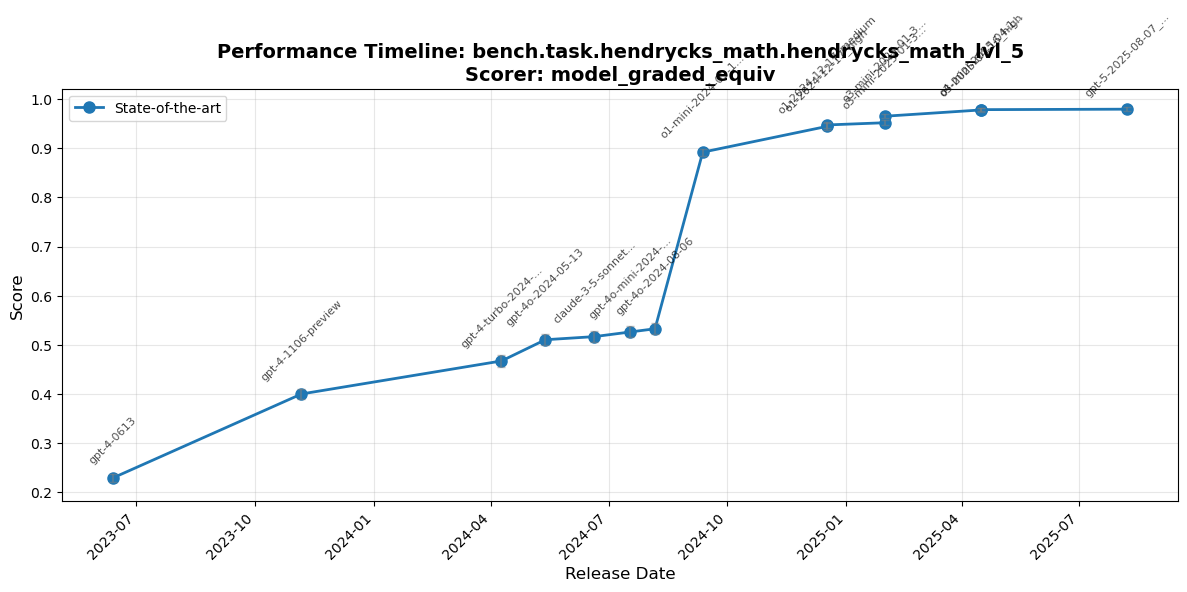


Showing 15 frontier improvements over time
Initial best score: 0.230
Current best score: 0.979
Total improvement: 0.750


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

def plot_performance_timeline(task_path: str, scorer: str, scores: list[Score]):
    """Plot the performance timeline showing frontier improvements over time."""
    
    # Get all scores for the task and scorer
    task_scores = []
    for score in scores:
        try:
            if score.benchmark_run is None:
                continue
            run = score.benchmark_run
            if run.task and run.task.path == task_path and score.scorer == scorer:
                if run.model.release_date:  # Only include scores with dates
                    task_scores.append(score)
        except Exception:
            continue
    
    if not task_scores:
        print(f"No scores found for {task_path} with {scorer}")
        return
    
    # Sort scores by release date
    task_scores = sorted(task_scores, key=lambda x: x.benchmark_run.model.release_date)
    
    # Find frontier improvements over time
    best_score = float('-inf')
    improvements = []
    
    for score in task_scores:
        if score.mean > best_score:
            best_score = score.mean
            improvements.append({
                'date': score.benchmark_run.model.release_date,
                'model': score.benchmark_run.model.model_id,
                'score': score.mean,
                'stderr': score.stderr if score.stderr else 0
            })
    
    # Extract data for plotting
    dates = [imp['date'] for imp in improvements]
    scores_values = [imp['score'] for imp in improvements]
    errors = [imp['stderr'] for imp in improvements]
    model_names = [imp['model'] for imp in improvements]
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot the frontier line
    ax.plot(dates, scores_values, 'o-', linewidth=2, markersize=8, label='State-of-the-art')
    
    # Add error bars
    ax.errorbar(dates, scores_values, yerr=errors, fmt='none', ecolor='gray', alpha=0.5, capsize=3)
    
    # Customize the plot
    ax.set_xlabel('Release Date', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title(f'Performance Timeline: {task_path}\nScorer: {scorer}', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10)
    
    # Format x-axis dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.xticks(rotation=45, ha='right')
    
    # Add annotations for each point
    for i, (date, score, model) in enumerate(zip(dates, scores_values, model_names)):
        # Truncate long model names
        display_name = model if len(model) <= 20 else model[:17] + '...'
        ax.annotate(display_name, 
                   (date, score),
                   textcoords="offset points",
                   xytext=(0, 10),
                   ha='center',
                   fontsize=8,
                   rotation=45,
                   alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nShowing {len(improvements)} frontier improvements over time")
    print(f"Initial best score: {improvements[0]['score']:.3f}")
    print(f"Current best score: {improvements[-1]['score']:.3f}")
    print(f"Total improvement: {improvements[-1]['score'] - improvements[0]['score']:.3f}")

# Plot the timeline
plot_performance_timeline(
    task_path="bench.task.hendrycks_math.hendrycks_math_lvl_5",
    scorer="model_graded_equiv",
    scores=scores
)

In [28]:
sorted(set([score.benchmark_run.task.path for score in scores if score.benchmark_run is not None]))

['bench.task.frontiermath.frontiermath_2025_02_28_private',
 'bench.task.frontiermath.frontiermath_2025_02_28_public',
 'bench.task.frontiermath.frontiermath_tier_4_2025_07_01_private',
 'bench.task.frontiermath.frontiermath_tier_4_2025_07_01_public',
 'bench.task.gpqa.gpqa_diamond',
 'bench.task.hendrycks_math.hendrycks_math_lvl_5',
 'bench.task.otis_mock_aime.otis_mock_aime_24_25',
 'bench.task.swe_bench.swe_bench_verified']

In [29]:
sorted(set([(score.benchmark_run.task.path, score.scorer) for score in scores if score.benchmark_run is not None]))

[('bench.task.frontiermath.frontiermath_2025_02_28_private',
  'manual_inspection'),
 ('bench.task.frontiermath.frontiermath_2025_02_28_private',
  'verification_code'),
 ('bench.task.frontiermath.frontiermath_2025_02_28_public',
  'verification_code'),
 ('bench.task.frontiermath.frontiermath_tier_4_2025_07_01_private',
  'manual_inspection'),
 ('bench.task.frontiermath.frontiermath_tier_4_2025_07_01_private',
  'verification_code'),
 ('bench.task.frontiermath.frontiermath_tier_4_2025_07_01_public',
  'verification_code'),
 ('bench.task.gpqa.gpqa_diamond', 'choice'),
 ('bench.task.hendrycks_math.hendrycks_math_lvl_5', 'model_graded_equiv'),
 ('bench.task.hendrycks_math.hendrycks_math_lvl_5', 'normalized_string_match'),
 ('bench.task.hendrycks_math.hendrycks_math_lvl_5', 'sympy_equiv'),
 ('bench.task.otis_mock_aime.otis_mock_aime_24_25',
  'model_extracted_exact_match'),
 ('bench.task.otis_mock_aime.otis_mock_aime_24_25', 'model_graded'),
 ('bench.task.swe_bench.swe_bench_verified', 'sw

## Merge scores per benchmark

In [30]:
import pandas as pd
from collections import defaultdict
import numpy as np

def extract_benchmark_matrices_dense(scores: list[Score]):
    """
    Extract benchmark data as matrices with only actual data (no NaN padding).
    Only includes dates where at least one model has a measurement.
    
    Returns:
        dict: {
            task_path: {
                'data': list of dicts with 'date', 'model_id', 'avg_score', 'scorers_used',
                'df_long': DataFrame in long format (no NaN),
                'df_wide': DataFrame in wide format (dates with data × models),
                'scorers': list of all scorers,
                'n_observations': total number of model-date observations
            }
        }
    """
    
    # Collect all scores
    benchmark_data = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(float))))
    # Structure: {task_path: {model_id: {date: {scorer: score}}}}
    
    for score in scores:
        try:
            if score.benchmark_run is None:
                continue
            run = score.benchmark_run
            
            if (run.task and run.task.path and 
                run.model and run.model.model_id and 
                run.model.release_date and 
                score.scorer and score.mean is not None):
                
                task_path = run.task.path
                model_id = run.model.model_id
                date = run.model.release_date
                scorer = score.scorer
                
                benchmark_data[task_path][model_id][date][scorer] = float(score.mean)
        except Exception:
            continue
    
    # Build dense data structure
    result = {}
    
    for task_path, models_dict in benchmark_data.items():
        all_scorers = set()
        data_rows = []
        
        # First pass: collect all observations and identify dates with data
        dates_with_data = set()
        for model_id, dates_dict in models_dict.items():
            for date, scorers_dict in dates_dict.items():
                dates_with_data.add(date)
                all_scorers.update(scorers_dict.keys())
                
                # Calculate average score across scorers for this observation
                scores_list = list(scorers_dict.values())
                avg_score = np.mean(scores_list)
                
                data_rows.append({
                    'date': date,
                    'model_id': model_id,
                    'avg_score': avg_score,
                    'n_scorers': len(scorers_dict),
                    'scorers_used': sorted(list(scorers_dict.keys()))
                })
        
        # Create DataFrame (long format)
        df_long = pd.DataFrame(data_rows)
        df_long = df_long.sort_values(['date', 'model_id']).reset_index(drop=True)
        
        # Create wide format: only dates with at least one measurement
        sorted_dates = sorted(list(dates_with_data))
        all_models = sorted(list(models_dict.keys()))
        
        # Build matrix for dates with data
        matrix_data = []
        for date in sorted_dates:
            row = []
            for model_id in all_models:
                if model_id in models_dict and date in models_dict[model_id]:
                    scores_at_date = list(models_dict[model_id][date].values())
                    avg_score = np.mean(scores_at_date)
                else:
                    avg_score = np.nan  # Model exists but no data at this date
                row.append(avg_score)
            matrix_data.append(row)
        
        df_wide = pd.DataFrame(
            matrix_data,
            index=sorted_dates,
            columns=all_models
        )
        
        # Calculate metrics
        total_cells = len(sorted_dates) * len(all_models)
        non_null_cells = df_wide.notna().sum().sum()
        density = non_null_cells / total_cells if total_cells > 0 else 0
        
        result[task_path] = {
            'data': data_rows,
            'df_long': df_long,
            'df_wide': df_wide,
            'scorers': sorted(list(all_scorers)),
            'n_observations': len(data_rows),
            'n_models': len(all_models),
            'n_dates': len(sorted_dates),
            'n_scorers': len(all_scorers),
            'density': density
        }
    
    return result

# Extract the matrices
benchmark_matrices = extract_benchmark_matrices_dense(scores)

# Display summary
print("="*80)
print("BENCHMARK MATRICES SUMMARY (Dense - Only Dates with Data)")
print("="*80)

for task_path, data in sorted(benchmark_matrices.items()):
    print(f"\n{task_path}:")
    print(f"  Models: {data['n_models']}")
    print(f"  Dates with data: {data['n_dates']}")
    print(f"  Scorers: {data['n_scorers']} - {data['scorers']}")
    print(f"  Total observations: {data['n_observations']}")
    print(f"  Wide matrix shape: {data['df_wide'].shape}")
    print(f"  Matrix density: {data['density']:.1%}")
    print(f"  Non-null values: {data['df_wide'].notna().sum().sum()}")

# Example: Display matrix for MATH Level 5
if "bench.task.hendrycks_math.hendrycks_math_lvl_5" in benchmark_matrices:
    print("\n" + "="*80)
    print("MATH Level 5 - Long Format (first 10 observations):")
    print("="*80)
    math_long = benchmark_matrices["bench.task.hendrycks_math.hendrycks_math_lvl_5"]['df_long']
    print(math_long.head(10))
    
    print("\n" + "="*80)
    print("MATH Level 5 - Wide Matrix (first 10 dates, first 5 models):")
    print("="*80)
    math_wide = benchmark_matrices["bench.task.hendrycks_math.hendrycks_math_lvl_5"]['df_wide']
    print(math_wide.iloc[:10, :5])
    
    print("\n" + "="*80)
    print("MATH Level 5 - Statistics:")
    print("="*80)
    print(f"Shape: {math_wide.shape}")
    print(f"Dates range: {math_wide.index[0]} to {math_wide.index[-1]}")
    print(f"Non-null cells: {math_wide.notna().sum().sum()} / {math_wide.shape[0] * math_wide.shape[1]}")
    print("\nScore statistics (all non-null values):")
    print(math_wide.stack().describe())

BENCHMARK MATRICES SUMMARY (Dense - Only Dates with Data)

bench.task.frontiermath.frontiermath_2025_02_28_private:
  Models: 56
  Dates with data: 30
  Scorers: 2 - ['manual_inspection', 'verification_code']
  Total observations: 56
  Wide matrix shape: (30, 56)
  Matrix density: 3.3%
  Non-null values: 56

bench.task.frontiermath.frontiermath_2025_02_28_public:
  Models: 59
  Dates with data: 33
  Scorers: 1 - ['verification_code']
  Total observations: 59
  Wide matrix shape: (33, 59)
  Matrix density: 3.0%
  Non-null values: 59

bench.task.frontiermath.frontiermath_tier_4_2025_07_01_private:
  Models: 25
  Dates with data: 16
  Scorers: 2 - ['manual_inspection', 'verification_code']
  Total observations: 25
  Wide matrix shape: (16, 25)
  Matrix density: 6.2%
  Non-null values: 25

bench.task.frontiermath.frontiermath_tier_4_2025_07_01_public:
  Models: 27
  Dates with data: 16
  Scorers: 1 - ['verification_code']
  Total observations: 27
  Wide matrix shape: (16, 27)
  Matrix dens

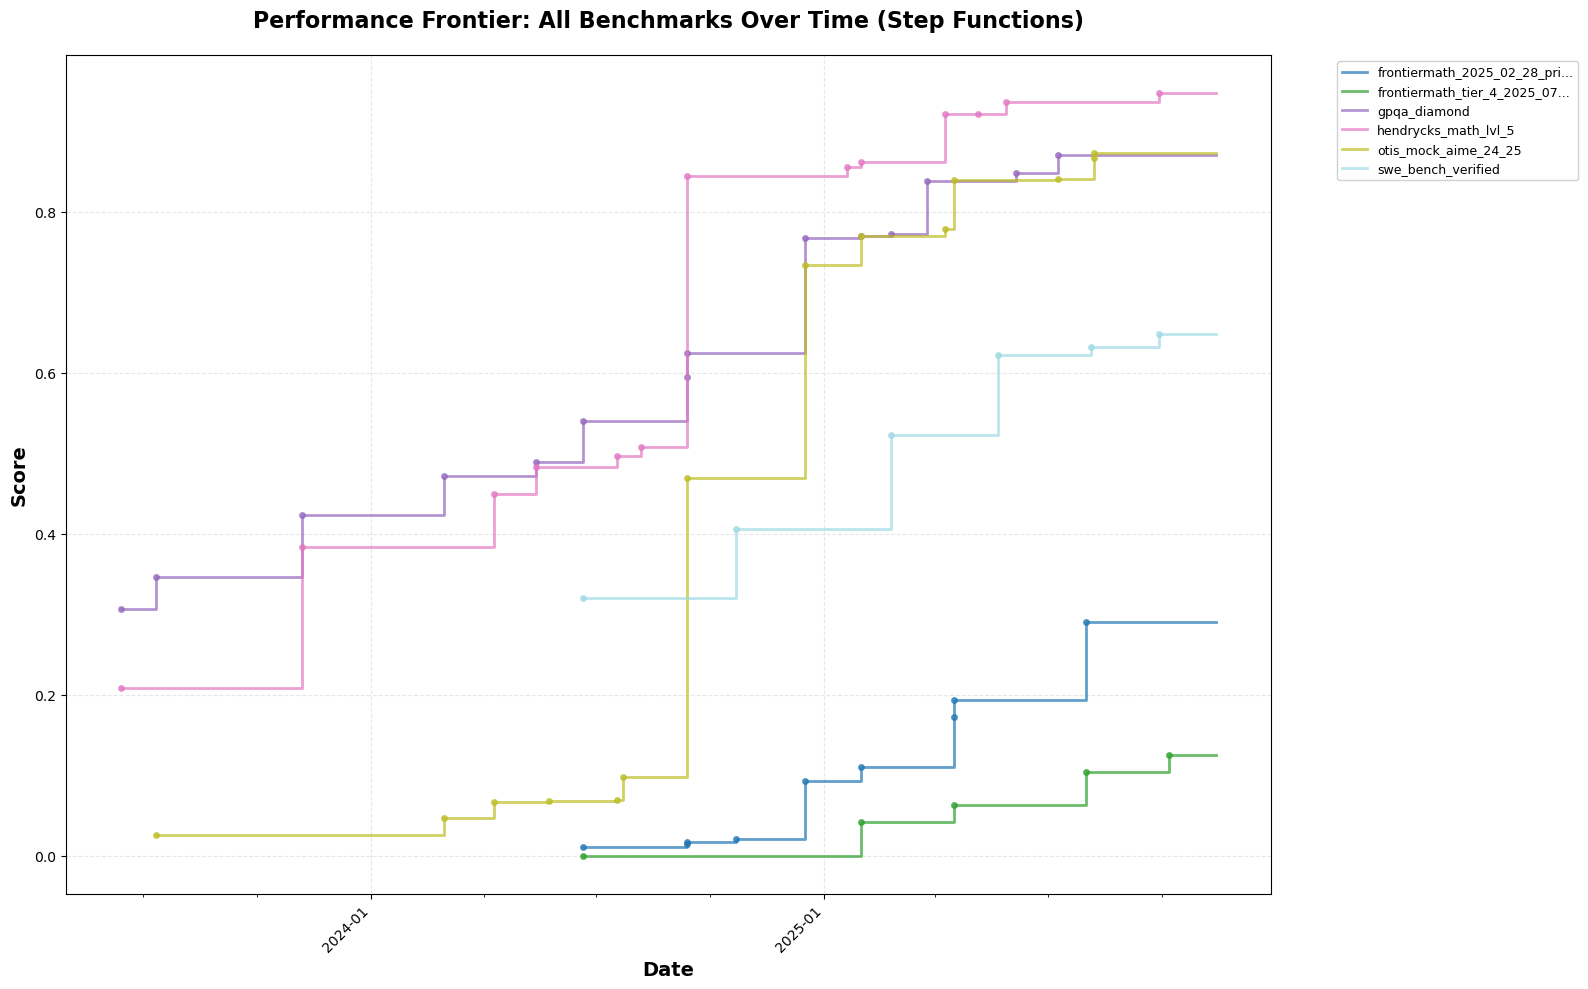


BENCHMARK IMPROVEMENTS SUMMARY

otis_mock_aime_24_25:
  Initial score: 0.025
  Current score: 0.872
  Improvement: 0.847 (3388.9%)
  # of frontier updates: 14

hendrycks_math_lvl_5:
  Initial score: 0.209
  Current score: 0.947
  Improvement: 0.739 (354.3%)
  # of frontier updates: 13

gpqa_diamond:
  Initial score: 0.307
  Current score: 0.870
  Improvement: 0.563 (183.8%)
  # of frontier updates: 14

swe_bench_verified:
  Initial score: 0.320
  Current score: 0.648
  Improvement: 0.328 (102.5%)
  # of frontier updates: 6

frontiermath_2025_02_28_pri...:
  Initial score: 0.010
  Current score: 0.290
  Improvement: 0.280 (2703.3%)
  # of frontier updates: 9

frontiermath_tier_4_2025_07...:
  Initial score: 0.000
  Current score: 0.125
  Improvement: 0.125 (∞% - from zero)
  # of frontier updates: 5


In [31]:
def plot_all_benchmarks_frontier_stepwise(benchmark_matrices, exclude_patterns=None):
    """
    Plot the performance frontier for all benchmarks on the same graph using step functions.
    Uses df_long to track best score over time for each benchmark.
    
    Args:
        benchmark_matrices: dict from extract_benchmark_matrices_dense
        exclude_patterns: list of strings to exclude (if any task_path contains these)
    """
    
    if exclude_patterns is None:
        exclude_patterns = []
    
    fig, ax = plt.subplots(figsize=(16, 10))
    
    # Filter out excluded benchmarks
    filtered_items = []
    for task_path, data in sorted(benchmark_matrices.items()):
        # Check if task should be excluded
        should_exclude = any(pattern in task_path for pattern in exclude_patterns)
        if not should_exclude:
            filtered_items.append((task_path, data))
    
    # Color palette for different benchmarks
    colors = plt.cm.tab20(np.linspace(0, 1, len(filtered_items)))
    
    benchmark_stats = []
    
    # Find global date range for extending step functions
    all_dates = []
    for task_path, data in filtered_items:
        df_long = data['df_long']
        if not df_long.empty:
            all_dates.extend(df_long['date'].tolist())
    
    if not all_dates:
        print("No data to plot")
        return
    
    global_date_min = min(all_dates)
    global_date_max = max(all_dates) + timedelta(days=30)
    
    for idx, (task_path, data) in enumerate(filtered_items):
        df_long = data['df_long']
        
        if df_long.empty:
            continue
        
        # Sort by date
        df_sorted = df_long.sort_values('date')
        
        # Calculate frontier (best score over time)
        best_score = float('-inf')
        frontier_improvements = []
        
        for _, row in df_sorted.iterrows():
            if row['avg_score'] > best_score:
                best_score = row['avg_score']
                frontier_improvements.append({
                    'date': row['date'],
                    'score': row['avg_score']
                })
        
        if not frontier_improvements:
            continue
        
        # Create step function data
        step_dates = []
        step_scores = []
        
        # Start from the first improvement
        first_improvement = frontier_improvements[0]
        step_dates.append(first_improvement['date'])
        step_scores.append(first_improvement['score'])
        
        for i in range(1, len(frontier_improvements)):
            # Add point just before the improvement (continuing previous score)
            step_dates.append(frontier_improvements[i]['date'])
            step_scores.append(frontier_improvements[i-1]['score'])
            
            # Add the improvement point
            step_dates.append(frontier_improvements[i]['date'])
            step_scores.append(frontier_improvements[i]['score'])
        
        # Extend the last score to the end
        step_dates.append(global_date_max)
        step_scores.append(frontier_improvements[-1]['score'])
        
        # Shorten task name for legend
        task_name = task_path.split('.')[-1]
        if len(task_name) > 30:
            task_name = task_name[:27] + '...'
        
        # Plot step function frontier
        ax.plot(step_dates, step_scores, '-', 
                linewidth=2, 
                label=task_name, color=colors[idx], alpha=0.7)
        
        # Plot markers at improvement points
        improvement_dates = [imp['date'] for imp in frontier_improvements]
        improvement_scores = [imp['score'] for imp in frontier_improvements]
        ax.plot(improvement_dates, improvement_scores, 'o', 
                markersize=4, color=colors[idx], alpha=0.7)
        
        # Store stats
        benchmark_stats.append({
            'task': task_name,
            'initial': frontier_improvements[0]['score'],
            'final': frontier_improvements[-1]['score'],
            'improvement': frontier_improvements[-1]['score'] - frontier_improvements[0]['score'],
            'n_improvements': len(frontier_improvements)
        })
    
    # Customize plot
    ax.set_xlabel('Date', fontsize=14, fontweight='bold')
    ax.set_ylabel('Score', fontsize=14, fontweight='bold')
    ax.set_title('Performance Frontier: All Benchmarks Over Time (Step Functions)', 
                 fontsize=16, fontweight='bold', pad=20)
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Format x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator([1, 4, 7, 10]))
    plt.xticks(rotation=45, ha='right')
    
    # Legend
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
              fontsize=9, framealpha=0.9)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*80)
    print("BENCHMARK IMPROVEMENTS SUMMARY")
    print("="*80)
    
    stats_df = pd.DataFrame(benchmark_stats)
    stats_df = stats_df.sort_values('improvement', ascending=False)
    
    for _, row in stats_df.iterrows():
        print(f"\n{row['task']}:")
        print(f"  Initial score: {row['initial']:.3f}")
        print(f"  Current score: {row['final']:.3f}")
        print(f"  Improvement: {row['improvement']:.3f}", end='')
        
        # Handle percentage calculation when initial score is 0
        if row['initial'] == 0:
            if row['improvement'] > 0:
                print(" (∞% - from zero)")
            else:
                print(" (0%)")
        else:
            pct_change = (row['improvement'] / row['initial']) * 100
            print(f" ({pct_change:.1f}%)")
        
        print(f"  # of frontier updates: {row['n_improvements']}")

# Plot all internal benchmarks with step functions
plot_all_benchmarks_frontier_stepwise(
    benchmark_matrices, 
    exclude_patterns=['public']
)

# EpochAI BD of External Benchmarks

## Load benchmarks

In [ ]:
import os, requests, urllib.parse, pandas as pd
from datetime import datetime, date
from collections import defaultdict
import numpy as np

# ============================================================================
# CONFIGURATION
# ============================================================================

TOKEN = "patmLNrsw9vgXl4la.4deb7e597571198c6bce5e65fc3c5abf0b0adbef0c6f9d9d9ea1320506ed477f"
#BASE_ID = 'appyrAKkx5f7xSVgl' # EpochAI BD of Internal Benchmarks
BASE_ID = 'appDzxPjO9mC6OHWy' # EpochAI BD of External Benchmarks
HEADERS = {"Authorization": f"Bearer {TOKEN}"}

os.environ['AIRTABLE_PERSONAL_ACCESS_TOKEN'] = TOKEN
os.environ['AIRTABLE_BASE_ID'] = BASE_ID

# Tables à exclure (métadonnées, non-normalized benchmarks)
EXCLUDED_TABLES = {
    'Model versions', 'ML Models', 'ML Domains', 'ML Tasks', 
    'Organizations', 'Chip dataset', 
    'METR horizon lengths', 'AidanBench', 'Factorio Learning Environment', 'WebDevArena',  # Non-normalized benchmarks
    'MCBench', 'VendingBench', 'GeoBench',   # Non-normalized benchmarks
    'WeirdML V1 (deprecated)',
    'GPQA-Diamond',                          # Already available with more datapoints as an internal benchmark
    'TEMPLATE', 'TEST', 'RE-Bench', 'HCAST'  # Tables vides
}

# ============================================================================
# AIRTABLE API HELPERS
# ============================================================================

def list_tables(base_id: str) -> list:
    """Liste toutes les tables d'une base Airtable."""
    url = f"https://api.airtable.com/v0/meta/bases/{base_id}/tables"
    r = requests.get(url, headers=HEADERS, timeout=20)
    r.raise_for_status()
    return r.json().get("tables", [])

def fetch_all_records(base_id: str, table_id_or_name: str, view: str = None) -> list:
    """Récupère tous les enregistrements d'une table (avec pagination)."""
    records = []
    encoded = urllib.parse.quote(table_id_or_name, safe='')
    url = f"https://api.airtable.com/v0/{base_id}/{encoded}"
    params = {"pageSize": 100}
    if view:
        params["view"] = view
    
    while True:
        r = requests.get(url, headers=HEADERS, params=params, timeout=30)
        r.raise_for_status()
        data = r.json()
        records.extend(data.get("records", []))
        offset = data.get("offset")
        if not offset:
            break
        params["offset"] = offset
    
    return records

# ============================================================================
# DATA NORMALIZATION
# ============================================================================

def parse_percent_or_number(s) -> float:
    """Convertit '58,8%' / '0.588' / '58.8%' en float (0..1)."""
    if s is None:
        return None
    if isinstance(s, (int, float)):
        return float(s)
    t = str(s).strip()
    if t == "":
        return None
    if t.endswith("%"):
        t2 = t[:-1].strip().replace(",", ".")
        try:
            return float(t2) / 100.0
        except:
            return None
    t = t.replace(",", ".")
    try:
        return float(t)
    except:
        return None

def parse_date(date_value):
    """Parse une date depuis différents formats."""
    if date_value is None:
        return None
    if isinstance(date_value, date):
        return date_value
    if isinstance(date_value, str):
        for fmt in ("%Y-%m-%d", "%d/%m/%Y", "%Y/%m/%d", "%Y-%m"):
            try:
                return datetime.strptime(date_value, fmt).date()
            except:
                continue
    return None

def detect_field_mapping(records: list, table_name: str) -> dict:
    """
    Détecte automatiquement le mapping des champs pour une table.
    Version améliorée: vérifie plusieurs enregistrements pour trouver tous les champs.
    Retourne un dict {champ_cible: nom_champ_airtable}.
    """
    if not records:
        return {}
    
    # Collecter tous les champs possibles des N premiers enregistrements
    all_fields = set()
    sample_size = min(10, len(records))
    
    for rec in records[:sample_size]:
        all_fields.update(rec.get("fields", {}).keys())
    
    mapping = {}
    
    # Détection du champ model_version (priorité aux champs les plus communs)
    for field in ['Model version', 'Model Version', 'model version', 'Version']:
        if field in all_fields:
            mapping['model_version'] = field
            break
    
    # Détection du champ score (mean) - élargi avec les champs trouvés
    for field in [
        'Score',                          # 10 tables - le plus commun
        'Accuracy',                       # 3 tables
        'Accuracy (pass@1)',              # 3 tables
        'Percent correct',                # 1 table
        'Accuracy mean',                  # 1 table
        '% Accuracy mean',
        'Mean',
        'Pass rate',
        'Mean score',
        'Average score',
        'Total score',
        'Overall accuracy',
        'Weighted Score',
        'Arena Score',
        'Production score',
        '% Score',
        'EM',                             
        'Global average',                 # LiveBench
        'Average progress',               # Balrog
        '% Score',                        # The Agent Company
        'Score (AVG@5)',                  # SimpleBench
        'Unguided % Solved',              # Cybench
        '120k token score',               # Fiction.LiveBench
        'Overall pass (%)',               # CadEval
        'Correct',                        # VPCT
        'Average',                        # BBH
        'Score OPT@1',                    # GSO-Bench
        'Overall (no subtitles)',         # VideoMME
        'Challenge score'                 # ARC AI2
    ]:
        if field in all_fields:
            mapping['mean'] = field
            break
    
    # Détection du champ stderr - élargi
    for field in [
        'Margin of Error',                # 3 tables - le plus commun
        'Accuracy SE',                    # 1 table
        '% Accuracy SE',
        'Std Error',
        'stderr',
        'SE',
        'Standard Error',
        'Error',
        'Average Standard error',
        'CI Lower Bound',                 # Peut être utilisé pour calculer stderr
        'CI Upper Bound',
        'Score 95% CI'
    ]:
        if field in all_fields:
            mapping['stderr'] = field
            break
    
    # Détection du scorer/metric
    for field in [
        'Edit format',                    # 1 table
        'Scorer',
        'scorer',
        'Metric',
        'Evaluation method',
        'Method'
    ]:
        if field in all_fields:
            mapping['scorer'] = field
            break
    
    # Détection du nom de modèle - ordre de priorité basé sur fréquence
    for field in [
        'Name',                           # 30 tables - le plus commun
        'Model',                          # 5 tables
        'name',                           # 2 tables
        'Model name',
        'model_name',
        'Model ID',
        'model_id',
        'Agent'                           # 4 tables - utilisé comme nom de modèle
    ]:
        if field in all_fields:
            mapping['model_name'] = field
            break
    
    # Task = nom de la table par défaut
    mapping['task'] = table_name
    
    return mapping

def normalize_records(records: list, table_name: str, mapping: dict = None) -> list:
    """
    Normalise les enregistrements d'une table en structure unifiée.
    Structure cible: {model_version, model_name, mean, stderr, task, scorer, release_date, shots, raw}.
    """
    if mapping is None:
        mapping = detect_field_mapping(records, table_name)
    
    results = []
    
    for rec in records:
        f = rec.get("fields", {})
        
        # Extraction avec fallback
        def get_field(target_key):
            if target_key in mapping:
                field_name = mapping[target_key]
                if field_name in f:
                    return f[field_name]
            return None
        
        # Model version (souvent un lien vers une autre table)
        model_version_raw = get_field('model_version')
        model_version = None
        if isinstance(model_version_raw, list) and len(model_version_raw) > 0:
            model_version = model_version_raw[0]
        elif isinstance(model_version_raw, str):
            model_version = model_version_raw
        
        # Nom du modèle
        model_name = get_field('model_name') or f.get('name') or f.get('Name')
        
        # Score - normalization applied based on benchmark type
        mean_raw = get_field('mean')
        mean = parse_percent_or_number(mean_raw)
        
        # Normalize specific benchmarks
        
        if mean is not None:
            if table_name in ["Aider polyglot", "OS World (Screenshot)", "LiveBench"]:
                # Score is a percentage
                mean = mean / 100.0
            elif table_name == "Lech Mazur Writing":
                # Score is 0-10 scale
                mean = mean / 10.0
        
        stderr = parse_percent_or_number(get_field('stderr'))
        
        # Scorer
        scorer = get_field('scorer') or 'default'
        
        # Shots - extract from raw fields
        shots = None
        for shots_field in ['Shots', 'shots', 'n_shots', 'N shots', 'Few-shot']:
            if shots_field in f:
                shots_val = f[shots_field]
                if shots_val is not None:
                    try:
                        shots = int(shots_val)
                    except:
                        shots = str(shots_val)
                break
        
        # Task = nom de la table
        task = table_name
        
        results.append({
            "_id": rec.get("id"),
            "model_version": model_version,
            "model_name": model_name,
            "mean": mean,
            "stderr": stderr,
            "task": task,
            "scorer": scorer,
            "shots": shots,
            "release_date": None,  # À enrichir après
            "raw": f
        })
    
    return results

# ============================================================================
# DATA CLEANING FUNCTIONS
# ============================================================================

def filter_rows_with_model_version(df: pd.DataFrame) -> pd.DataFrame:
    """
    Filtre le DataFrame pour ne garder que les lignes avec model_version.
    """
    before = len(df)
    df_filtered = df[df['model_version'].notna()].copy()
    after = len(df_filtered)
    
    print(f"Filtered out {before - after} rows without model_version ({(before-after)/before*100:.1f}%)")
    print(f"Remaining: {after} rows")
    
    return df_filtered

def select_optimal_shots_per_benchmark(df: pd.DataFrame, filter_by_shots: bool = True) -> pd.DataFrame:
    """
    Pour chaque benchmark, optionally sélectionne le nombre de shots qui maximise
    le nombre de model_version uniques conservées.
    Traite les valeurs nulles comme '0-shot' mais garde les strings comme 'few-shot'.
    
    Args:
        df: DataFrame with benchmark data
        filter_by_shots: If True, selects optimal shots per benchmark. If False, keeps all shots.
    """
    print("\n" + "="*80)
    if filter_by_shots:
        print("SELECTING OPTIMAL SHOTS PER BENCHMARK")
    else:
        print("KEEPING ALL SHOTS (NO FILTERING)")
    print("="*80)
    
    # Define normalize function once (used in both cases)
    def normalize_shots_to_str(val):
        if pd.isna(val) or val is None:
            return '0-shot'
        if isinstance(val, (int, float)):
            return f'{int(val)}-shot'
        val_str = str(val).strip().lower()
        if not val_str.endswith('-shot') and not val_str.endswith('shot'):
            try:
                num = int(val_str)
                return f'{num}-shot'
            except:
                return f'{val_str}-shot' if val_str else '0-shot'
        return val_str
    
    if not filter_by_shots:
        # Just normalize shots field and return all data
        df_copy = df.copy()
        df_copy['shots'] = df_copy['shots'].apply(normalize_shots_to_str)
        
        print(f"\nKept all {len(df_copy)} records across all shots configurations")
        return df_copy
    
    # Original logic: select optimal shots per benchmark
    df_result = []
    
    for task in df['task'].unique():
        task_df = df[df['task'] == task].copy()
        
        # Normalize shots
        task_df['shots'] = task_df['shots'].apply(normalize_shots_to_str)
        
        # Compter le nombre de model_version uniques par shots
        shots_coverage = {}
        for shots_val in task_df['shots'].unique():
            shots_df = task_df[task_df['shots'] == shots_val]
            n_unique_versions = shots_df['model_version'].nunique()
            shots_coverage[shots_val] = n_unique_versions
        
        # Trouver le shots qui maximise la couverture
        if shots_coverage:
            optimal_shots = max(shots_coverage, key=shots_coverage.get)
            optimal_df = task_df[task_df['shots'] == optimal_shots].copy()
            
            # Sort shots for display (numeric first, then alphabetic)
            def sort_key(s):
                import re
                match = re.match(r'^(\d+)', s)
                if match:
                    return (0, int(match.group(1)))
                else:
                    return (1, s)
            
            sorted_shots = sorted(shots_coverage.keys(), key=sort_key)
            
            print(f"\n{task}:")
            print(f"  Available shots: {sorted_shots}")
            print(f"  Coverage per shots: {shots_coverage}")
            print(f"  Selected: {optimal_shots} ({shots_coverage[optimal_shots]} unique models)")
            print(f"  Kept {len(optimal_df)}/{len(task_df)} records")
            
            df_result.append(optimal_df)
        else:
            print(f"\n{task}: No data (skipped)")
    
    if df_result:
        result = pd.concat(df_result, ignore_index=True)
    else:
        result = pd.DataFrame()
    
    print(f"\n{'='*80}")
    print(f"TOTAL: Reduced from {len(df)} to {len(result)} records")
    print(f"{'='*80}")
    
    return result

def clean_external_benchmarks(df: pd.DataFrame, filter_by_shots: bool = True) -> pd.DataFrame:
    """
    Pipeline complet de nettoyage:
    1. Filtre les lignes sans model_version
    2. Optionally sélectionne optimal shots par benchmark (or keeps all)
    3. Remove remaining duplicates
    
    Args:
        df: DataFrame with benchmark data
        filter_by_shots: If True, selects optimal shots per benchmark and aggregates by median.
                        If False, keeps all shots and aggregates by maximum.
    """
    print("\n" + "="*80)
    print("CLEANING PIPELINE")
    print("="*80)
    
    # Step 1: Filter rows without model_version
    print("\n[Step 1] Filtering rows without model_version...")
    df = filter_rows_with_model_version(df)
    
    # Step 2: Select optimal shots per benchmark OR keep all
    print("\n[Step 2] Processing shots...")
    df = select_optimal_shots_per_benchmark(df, filter_by_shots=filter_by_shots)
    
    # Step 3: Remove any remaining duplicates
    print("\n[Step 3] Aggregating duplicates...")
    before = len(df)
    
    if filter_by_shots:
        # Use median when filtering by shots (optimal shot selection)
        print("  Using MEDIAN aggregation (optimal shots selected)")
        df = (
            df.groupby(['model_version', 'task', 'scorer', 'release_date'], as_index=False)
            .median(numeric_only=True)
        )
    else:
        # Use maximum when keeping all shots (to get best performance)
        print("  Using MAXIMUM aggregation (all shots kept)")
        df = (
            df.groupby(['model_version', 'task', 'scorer', 'release_date'], as_index=False)
            .max(numeric_only=True)
        )

    after = len(df)
    print(f"  Reduced from {before} to {after} rows.")
    
    print("\n" + "="*80)
    print("CLEANING COMPLETE")
    print("="*80)
    print(f"Final dataset: {len(df)} records")
    print(f"  Benchmarks: {df['task'].nunique()}")
    print(f"  Unique models: {df['model_version'].nunique()}")
    print(f"  Date coverage: {df['release_date'].notna().sum() / len(df) * 100:.1f}%")
    
    return df

# ============================================================================
# MODEL VERSIONS ENRICHMENT
# ============================================================================

def build_model_version_lookup(base_id: str) -> dict:
    """
    Construit un dictionnaire {record_id: release_date} depuis la table Model versions.
    """
    try:
        records = fetch_all_records(base_id, "Model versions")
        print(f"  Fetched {len(records)} model version records")
    except Exception as e:
        print(f"Warning: Could not fetch Model versions - {e}")
        return {}
    
    lookup = {}
    date_fields_found = set()
    
    for rec in records:
        f = rec.get("fields", {})
        rec_id = rec.get("id")
        
        # Chercher le champ date
        release_raw = None
        field_name_date = 'Version release date'
        if field_name_date in f:
            release_raw = f[field_name_date]
            date_fields_found.add(field_name_date)
        
        release_date = parse_date(release_raw)
        if release_date:
            lookup[rec_id] = release_date
    
    if date_fields_found:
        print(f"  Date fields found: {date_fields_found}")
    
    return lookup

def enrich_with_release_dates(normalized_scores: list, 
                              model_version_lookup: dict):
    """
    Ajoute les dates de release aux scores normalisés (in-place).
    Utilise le model_version ID pour lookup.
    """
    enriched_count = 0
    future_dates_count = 0
    today = date.today()
    
    for score in normalized_scores:
        mv_id = score.get("model_version")
        if mv_id and mv_id in model_version_lookup:
            release_date = model_version_lookup[mv_id]
            if release_date > today:
                future_dates_count += 1
                continue  # Skip future dates
            score["release_date"] = release_date
            enriched_count += 1
    
    if future_dates_count > 0:
        print(f"  ⚠️  Skipped {future_dates_count} records with future dates")
    print(f"  Enriched dates: {enriched_count} via version ID")

# ============================================================================
# BENCHMARK EXTRACTION PIPELINE
# ============================================================================
    
def get_benchmark_tables(base_id: str, excluded: set = None) -> list:
    """
    Retourne la liste des tables qui sont des benchmarks (exclut les tables de métadonnées).
    """
    if excluded is None:
        excluded = EXCLUDED_TABLES
    
    tables = list_tables(base_id)
    benchmark_tables = [
        t for t in tables 
        if t.get("name") not in excluded
    ]
    
    return benchmark_tables

def load_all_external_benchmarks(base_id: str) -> pd.DataFrame:
    """
    Charge tous les benchmarks externes et retourne un DataFrame unifié.
    """
    # 1. Identifier les tables de benchmarks
    benchmark_tables = get_benchmark_tables(base_id)
    print(f"Found {len(benchmark_tables)} benchmark tables")
    
    # 2. Charger le lookup de dates via model_version
    print("Building model version lookup...")
    model_version_lookup = build_model_version_lookup(base_id)
    print(f"  ✓ {len(model_version_lookup)} versions with dates")
    
    # 3. Charger et normaliser chaque benchmark
    all_scores = []
    
    for table in benchmark_tables:
        table_name = table.get("name")
        try:
            print(f"Loading {table_name}...")
            records = fetch_all_records(base_id, table_name)
            
            if not records:
                print(f"  ⚠ No records found")
                continue
            
            normalized = normalize_records(records, table_name)
            enrich_with_release_dates(normalized, model_version_lookup)
            
            all_scores.extend(normalized)
            print(f"  ✓ {len(normalized)} scores")
            
        except Exception as e:
            print(f"  ✗ Error: {e}")
    
    # 4. Convertir en DataFrame
    df = pd.DataFrame(all_scores)
    
    # Nettoyer: supprimer les lignes sans score
    df = df[df['mean'].notna()].reset_index(drop=True)
    
    print(f"\n{'='*80}")
    print(f"TOTAL: {len(df)} scores from {df['task'].nunique()} benchmarks")
    print(f"  Models: {df['model_name'].nunique()}")
    print(f"  Scores with dates: {df['release_date'].notna().sum()}")
    print(f"  Scores without dates: {df['release_date'].isna().sum()}")
    print(f"  Date coverage: {df['release_date'].notna().sum() / len(df) * 100:.1f}%")
    print(f"{'='*80}")
    
    return df

# ============================================================================
# DIAGNOSTIC FUNCTION
# ============================================================================

def diagnose_missing_dates(df: pd.DataFrame):
    """Analyse pourquoi certains scores n'ont pas de dates."""
    print("\n" + "="*80)
    print("MISSING DATES DIAGNOSTIC")
    print("="*80)
    
    no_dates = df[df['release_date'].isna()]
    with_dates = df[df['release_date'].notna()]
    
    print(f"\nTotal scores without dates: {len(no_dates)} ({len(no_dates)/len(df)*100:.1f}%)")
    print(f"Total scores with dates: {len(with_dates)} ({len(with_dates)/len(df)*100:.1f}%)")
    
    if len(with_dates) > 0:
        print(f"\nDate range: {with_dates['release_date'].min()} to {with_dates['release_date'].max()}")
    
    if len(no_dates) > 0:
        print(f"\nTop 10 model names without dates:")
        print(no_dates['model_name'].value_counts().head(10))
        
        print(f"\nBenchmarks with missing dates:")
        missing_by_task = no_dates.groupby('task').size().sort_values(ascending=False)
        for task, count in missing_by_task.items():
            total = len(df[df['task'] == task])
            print(f"  {task}: {count}/{total} ({count/total*100:.1f}%)")

# ============================================================================
# MOCK Score CLASS FOR COMPATIBILITY
# ============================================================================

class MockScore:
    """Classe mock pour simuler l'interface de epochai.airtable.models.Score."""
    
    def __init__(self, row):
        self.mean = row.get('mean')
        self.stderr = row.get('stderr')
        self.scorer = row.get('scorer')
        self.model_id = row.get('model_name')
        self.release_date = row.get('release_date')
        self.task_path = row.get('task')
        self._raw = row

def dataframe_to_score_objects(df: pd.DataFrame) -> list:
    """Convertit un DataFrame en liste d'objets MockScore pour compatibilité."""
    return [MockScore(row) for _, row in df.iterrows()]

# ============================================================================
# BENCHMARK MATRICES (compatible avec code existant)
# ============================================================================

def extract_benchmark_matrices_from_df(df: pd.DataFrame) -> dict:
    """
    Version adaptée de extract_benchmark_matrices_dense qui prend un DataFrame.
    Retourne la même structure que la fonction originale.
    Utilise model_version au lieu de model_name pour plus de fiabilité.
    """
    # Filtrer les scores avec date
    df_dated = df[df['release_date'].notna()].copy()
    
    if df_dated.empty:
        print("Warning: No scores with release dates")
        return {}
    
    # Grouper par task
    result = {}
    
    for task in df_dated['task'].unique():
        task_df = df_dated[df_dated['task'] == task].copy()
        
        # Préparer les données au format attendu
        data_rows = []
        
        # Grouper par (model_version, date, scorer) et calculer moyenne si duplicates
        grouped = task_df.groupby(['model_version', 'release_date', 'scorer']).agg({
            'mean': 'mean',
            'stderr': 'mean'
        }).reset_index()
        
        # Re-grouper par (model_version, date) pour avoir avg_score
        for (model_version, date), group in grouped.groupby(['model_version', 'release_date']):
            avg_score = group['mean'].mean()
            scorers_used = sorted(group['scorer'].unique().tolist())
            
            data_rows.append({
                'date': date,
                'model_id': model_version,  # Using model_version as model_id
                'avg_score': avg_score,
                'n_scorers': len(scorers_used),
                'scorers_used': scorers_used
            })
        
        # Skip if no data rows (can happen if all scores for this task have no dates)
        if not data_rows:
            continue
        
        # DataFrame long
        df_long = pd.DataFrame(data_rows).sort_values(['date', 'model_id']).reset_index(drop=True)
        
        # DataFrame wide
        dates = sorted(df_long['date'].unique())
        models = sorted(df_long['model_id'].unique())
        
        # Construire matrice
        matrix_data = []
        for date in dates:
            row = []
            for model in models:
                match = df_long[(df_long['date'] == date) & (df_long['model_id'] == model)]
                if not match.empty:
                    row.append(match.iloc[0]['avg_score'])
                else:
                    row.append(np.nan)
            matrix_data.append(row)
        
        df_wide = pd.DataFrame(matrix_data, index=dates, columns=models)
        
        # Métriques
        all_scorers = sorted(task_df['scorer'].unique().tolist())
        density = df_wide.notna().sum().sum() / (len(dates) * len(models)) if len(dates) * len(models) > 0 else 0
        
        result[task] = {
            'data': data_rows,
            'df_long': df_long,
            'df_wide': df_wide,
            'scorers': all_scorers,
            'n_observations': len(data_rows),
            'n_models': len(models),
            'n_dates': len(dates),
            'n_scorers': len(all_scorers),
            'density': density
        }
    
    return result

# ============================================================================
# EXECUTION
# ============================================================================

# Charger tous les benchmarks externes
filter_by_shots = False  # False to keep all shots configurations
df_external_raw = load_all_external_benchmarks(BASE_ID)
df_external = clean_external_benchmarks(df_external_raw, filter_by_shots)

# Diagnostic
diagnose_missing_dates(df_external)

# Créer les matrices pour visualisation
if df_external['release_date'].notna().sum() > 0:
    benchmark_matrices_ext = extract_benchmark_matrices_from_df(df_external)
    
    print("\n" + "="*80)
    print("EXTERNAL BENCHMARK MATRICES SUMMARY")
    print("="*80)
    
    for task_path, data in sorted(benchmark_matrices_ext.items()):
        print(f"\n{task_path}:")
        print(f"  Models: {data['n_models']}")
        print(f"  Dates: {data['n_dates']}")
        print(f"  Scorers: {data['n_scorers']} - {data['scorers']}")
        print(f"  Observations: {data['n_observations']}")
        print(f"  Matrix shape: {data['df_wide'].shape}")
        print(f"  Density: {data['density']:.1%}")
    
    # Exemple: afficher quelques lignes du premier benchmark
    if benchmark_matrices_ext:
        first_task = list(benchmark_matrices_ext.keys())[0]
        print(f"\n" + "="*80)
        print(f"SAMPLE DATA: {first_task}")
        print("="*80)
        print(benchmark_matrices_ext[first_task]['df_long'].head(10))
else:
    print("\n⚠️  No dates found - cannot create benchmark matrices")
    print("Consider adding release dates to Model versions table")
    print("\nTo debug, inspect the Model versions table structure:")
    print("  df_external[df_external['model_version'].notna()][['model_name', 'model_version']].head()")

Found 39 benchmark tables
Building model version lookup...
  Fetched 560 model version records
  Date fields found: {'Version release date'}
  ✓ 526 versions with dates
Loading Aider polyglot...
  Enriched dates: 60 via version ID
  ✓ 65 scores
Loading OS World (Screenshot)...
  Enriched dates: 16 via version ID
  ✓ 44 scores
Loading LiveBench...
  Enriched dates: 51 via version ID
  ✓ 63 scores
Loading WeirdML V2...
  Enriched dates: 68 via version ID
  ✓ 69 scores
Loading Balrog...
  Enriched dates: 27 via version ID
  ✓ 27 scores
Loading The Agent Company...
  Enriched dates: 10 via version ID
  ✓ 10 scores
Loading SimpleBench...
  Enriched dates: 44 via version ID
  ✓ 44 scores
Loading Cybench...
  Enriched dates: 12 via version ID
  ✓ 12 scores
Loading Lech Mazur Writing...
  Enriched dates: 31 via version ID
  ✓ 31 scores
Loading Fiction.LiveBench...
  Enriched dates: 58 via version ID
  ✓ 60 scores
Loading CadEval...
  Enriched dates: 14 via version ID
  ✓ 15 scores
Loading VPCT

In [33]:
# ============================================================================
# DIAGNOSTIC: Voir quelles tables sont chargées et pourquoi certaines échouent
# ============================================================================

def load_all_external_benchmarks_with_diagnostics(base_id: str) -> pd.DataFrame:
    """
    Charge tous les benchmarks externes avec diagnostic détaillé.
    """
    # 1. Identifier les tables de benchmarks
    benchmark_tables = get_benchmark_tables(base_id)
    print(f"Found {len(benchmark_tables)} benchmark tables")
    
    # 2. Charger le lookup de dates via model_version
    print("\nBuilding model version lookup...")
    model_version_lookup = build_model_version_lookup(base_id)
    print(f"  ✓ {len(model_version_lookup)} versions with dates")
    
    # 3. Charger et normaliser chaque benchmark avec diagnostic
    all_scores = []
    successful_tables = []
    failed_tables = []
    skipped_tables = []
    
    for table in benchmark_tables:
        table_name = table.get("name")
        try:
            print(f"\n{'='*60}")
            print(f"Loading {table_name}...")
            records = fetch_all_records(base_id, table_name)
            
            if not records:
                print(f"  ⚠ No records found")
                skipped_tables.append((table_name, "No records"))
                continue
            
            print(f"  Fetched {len(records)} records")
            
            # Diagnostic: voir les champs disponibles
            if records:
                sample_fields = records[0].get("fields", {}).keys()
                print(f"  Sample fields: {list(sample_fields)[:10]}...")
            
            # Normaliser
            normalized = normalize_records(records, table_name)
            print(f"  Normalized to {len(normalized)} scores")
            
            # Diagnostic: compter les model_version
            n_with_version = sum(1 for s in normalized if s.get('model_version'))
            print(f"  Records with model_version: {n_with_version}/{len(normalized)} ({n_with_version/len(normalized)*100:.1f}%)")
            
            # Enrichir avec dates
            enrich_with_release_dates(normalized, model_version_lookup)
            
            # Diagnostic: compter les dates
            n_with_date = sum(1 for s in normalized if s.get('release_date'))
            print(f"  Records with release_date: {n_with_date}/{len(normalized)} ({n_with_date/len(normalized)*100:.1f}%)")
            
            # Compter les scores valides
            n_valid_scores = sum(1 for s in normalized if s.get('mean') is not None)
            print(f"  Records with valid scores: {n_valid_scores}/{len(normalized)} ({n_valid_scores/len(normalized)*100:.1f}%)")
            
            all_scores.extend(normalized)
            successful_tables.append(table_name)
            print(f"  ✓ Successfully loaded")
            
        except Exception as e:
            print(f"  ✗ Error: {e}")
            import traceback
            traceback.print_exc()
            failed_tables.append((table_name, str(e)))
    
    # 4. Convertir en DataFrame
    df = pd.DataFrame(all_scores)
    
    # Nettoyer: supprimer les lignes sans score
    before_clean = len(df)
    df = df[df['mean'].notna()].reset_index(drop=True)
    after_clean = len(df)
    
    print(f"\n{'='*80}")
    print(f"LOADING SUMMARY")
    print(f"{'='*80}")
    print(f"\nSuccessful tables ({len(successful_tables)}):")
    for t in successful_tables:
        print(f"  ✓ {t}")
    
    if skipped_tables:
        print(f"\nSkipped tables ({len(skipped_tables)}):")
        for t, reason in skipped_tables:
            print(f"  ⊘ {t}: {reason}")
    
    if failed_tables:
        print(f"\nFailed tables ({len(failed_tables)}):")
        for t, reason in failed_tables:
            print(f"  ✗ {t}: {reason}")
    
    print(f"\nDATA SUMMARY:")
    print(f"  Total raw records: {before_clean}")
    print(f"  Removed (no score): {before_clean - after_clean}")
    print(f"  Final records: {after_clean}")
    print(f"  Unique tasks: {df['task'].nunique()}")
    print(f"  Records with model_version: {df['model_version'].notna().sum()}")
    print(f"  Records with dates: {df['release_date'].notna().sum()}")
    print(f"  Date coverage: {df['release_date'].notna().sum() / len(df) * 100:.1f}%")
    print(f"{'='*80}")
    
    return df

# Recharger avec diagnostics
df_external_raw = load_all_external_benchmarks_with_diagnostics(BASE_ID)

Found 39 benchmark tables

Building model version lookup...
  Fetched 560 model version records
  Date fields found: {'Version release date'}
  ✓ 526 versions with dates

Loading Aider polyglot...
  Fetched 65 records
  Sample fields: ['name', 'Percent correct', 'Percent using correct edit format', 'Edit format', 'Source', 'Source link', 'Model version', 'id']...
  Normalized to 65 scores
  Records with model_version: 61/65 (93.8%)
  Enriched dates: 60 via version ID
  Records with release_date: 60/65 (92.3%)
  Records with valid scores: 65/65 (100.0%)
  ✓ Successfully loaded

Loading OS World (Screenshot)...
  Fetched 44 records
  Sample fields: ['Agent', 'Score', 'Source', 'Source link', 'Notes (details)', 'Model version', 'Date added']...
  Normalized to 44 scores
  Records with model_version: 16/44 (36.4%)
  Enriched dates: 16 via version ID
  Records with release_date: 16/44 (36.4%)
  Records with valid scores: 44/44 (100.0%)
  ✓ Successfully loaded

Loading LiveBench...
  Fetched

## Tests

In [34]:
# ============================================================================
# INLINE TESTS - Run directly in notebook
# ============================================================================

import pandas as pd
import numpy as np
from datetime import date

def run_all_tests():
    """Run all inline tests and report results."""
    
    tests_passed = 0
    tests_failed = 0
    
    def test(name, condition, error_msg=""):
        nonlocal tests_passed, tests_failed
        try:
            assert condition, error_msg
            print(f"✓ {name}")
            tests_passed += 1
        except AssertionError as e:
            print(f"✗ {name}: {e}")
            tests_failed += 1
        except Exception as e:
            print(f"✗ {name}: Unexpected error - {e}")
            tests_failed += 1
    
    print("="*80)
    print("RUNNING INLINE TESTS")
    print("="*80)
    
    # ========================================================================
    # Test 1: parse_percent_or_number
    # ========================================================================
    print("\n[1] Testing parse_percent_or_number...")
    test("Parse decimal", parse_percent_or_number("0.856") == 0.856)
    test("Parse percentage", abs(parse_percent_or_number("85.6%") - 0.856) < 0.001)
    test("Parse with comma", abs(parse_percent_or_number("85,6%") - 0.856) < 0.001)
    test("Parse None", parse_percent_or_number(None) is None)
    test("Parse empty string", parse_percent_or_number("") is None)
    test("Parse invalid", parse_percent_or_number("invalid") is None)
    
    # ========================================================================
    # Test 2: parse_date
    # ========================================================================
    print("\n[2] Testing parse_date...")
    test("Parse ISO date", parse_date("2023-03-14") == date(2023, 3, 14))
    test("Parse EU date", parse_date("14/03/2023") == date(2023, 3, 14))
    test("Parse year-month", parse_date("2023-03") == date(2023, 3, 1))
    test("Parse None", parse_date(None) is None)
    test("Parse invalid", parse_date("invalid") is None)
    
    # ========================================================================
    # Test 3: detect_field_mapping
    # ========================================================================
    print("\n[3] Testing detect_field_mapping...")
    sample_records = [
        {"fields": {"Name": "GPT-4", "Score": "0.85", "Model version": ["rec1"]}},
        {"fields": {"Name": "Claude", "Score": "0.80", "Model version": ["rec2"]}}
    ]
    mapping = detect_field_mapping(sample_records, "TestBenchmark")
    test("Detect model_version field", 'model_version' in mapping)
    test("Detect mean field", 'mean' in mapping)
    test("Detect task field", mapping.get('task') == "TestBenchmark")
    test("Empty records", detect_field_mapping([], "Test") == {})
    
    # ========================================================================
    # Test 4: normalize_records
    # ========================================================================
    print("\n[4] Testing normalize_records...")
    normalized = normalize_records(sample_records, "TestBenchmark")
    test("Normalize count", len(normalized) == 2)
    test("All have model_version", all('model_version' in rec for rec in normalized))
    test("All have mean", all('mean' in rec for rec in normalized))
    test("All have task", all(rec['task'] == 'TestBenchmark' for rec in normalized))
    test("Scores normalized to 0-1", 
         all(0 <= rec['mean'] <= 1 for rec in normalized if rec['mean'] is not None))
    
    # ========================================================================
    # Test 5: Data integrity checks on df_external
    # ========================================================================
    print("\n[5] Testing df_external data integrity...")
    test("DataFrame not empty", len(df_external) > 0)
    test("Has required columns", 
         all(col in df_external.columns for col in ['model_version', 'mean', 'task', 'scorer']))
    test("All scores in valid range", 
         df_external['mean'].dropna().between(0, 1).all(),
         f"Min: {df_external['mean'].min()}, Max: {df_external['mean'].max()}")
    test("No negative scores", (df_external['mean'] >= 0).all())
    test("Stderr values reasonable", 
         df_external['stderr'].dropna().between(0, 0.5).all() if len(df_external['stderr'].dropna()) > 0 else True)
    
    # ========================================================================
    # Test 6: Date consistency
    # ========================================================================
    print("\n[6] Testing date consistency...")
    dated_scores = df_external[df_external['release_date'].notna()]
    if len(dated_scores) > 0:
        test("Dates not in future", 
             (dated_scores['release_date'] <= date.today()).all())
        test("Dates not too old", 
             (dated_scores['release_date'] >= date(2015, 1, 1)).all())
        test("Date coverage reasonable",
             len(dated_scores) / len(df_external) > 0.3,
             f"Only {len(dated_scores)/len(df_external)*100:.1f}% have dates")
    else:
        print("  ⚠ No dates to test")
    
    # ========================================================================
    # Test 7: Benchmark matrices extraction
    # ========================================================================
    print("\n[7] Testing extract_benchmark_matrices_from_df...")
    if len(dated_scores) > 0:
        matrices = extract_benchmark_matrices_from_df(df_external)
        test("Matrices extracted", len(matrices) > 0)
        
        for task, data in list(matrices.items())[:3]:  # Test first 3
            test(f"Matrix {task[:30]} has df_long", 
                 isinstance(data.get('df_long'), pd.DataFrame))
            test(f"Matrix {task[:30]} has df_wide", 
                 isinstance(data.get('df_wide'), pd.DataFrame))
            test(f"Matrix {task[:30]} no NaN in df_long", 
                 not data['df_long']['avg_score'].isna().any())
            test(f"Matrix {task[:30]} density calculated", 
                 0 <= data.get('density', -1) <= 1)
    else:
        print("  ⚠ No dated scores to create matrices")
    
    # ========================================================================
    # Test 8: Score comparability across benchmarks
    # ========================================================================
    print("\n[8] Testing score comparability...")
    for task in df_external['task'].unique()[:5]:  # Test first 5 benchmarks
        task_scores = df_external[df_external['task'] == task]['mean'].dropna()
        if len(task_scores) > 1:
            test(f"{task[:30]} has variance", 
                 task_scores.var() > 0,
                 "All scores are identical")
    
    # ========================================================================
    # Test 9: Model version extraction
    # ========================================================================
    print("\n[9] Testing model version extraction...")
    missing_versions = df_external['model_version'].isna().sum()
    test("Most records have model versions", 
         missing_versions / len(df_external) < 0.1,
         f"{missing_versions} missing versions ({missing_versions/len(df_external)*100:.1f}%)")
    test("No empty model versions",
         all(len(str(version).strip()) > 0 for version in df_external['model_version'].dropna()))
    
    # ========================================================================
    # Test 10: Benchmark coverage
    # ========================================================================
    print("\n[10] Testing benchmark coverage...")
    n_benchmarks = df_external['task'].nunique()
    n_models = df_external['model_version'].nunique()  # Changed from model_name
    test("Multiple benchmarks loaded", 
         n_benchmarks >= 10,
         f"Only {n_benchmarks} benchmarks")
    test("Multiple models present", 
         n_models >= 20,
         f"Only {n_models} models")
    
    # ========================================================================
    # Test 11: MockScore class compatibility
    # ========================================================================
    print("\n[11] Testing MockScore class...")
    sample_row = {
        'mean': 0.85,
        'stderr': 0.02,
        'scorer': 'accuracy',
        'model_name': 'GPT-4',
        'release_date': date(2023, 3, 14),
        'task': 'MMLU'
    }
    mock_score = MockScore(sample_row)
    test("MockScore has mean", mock_score.mean == 0.85)
    test("MockScore has model_id", mock_score.model_id == 'GPT-4')
    test("MockScore has task_path", mock_score.task_path == 'MMLU')
    
    # ========================================================================
    # Test 12: dataframe_to_score_objects conversion
    # ========================================================================
    print("\n[12] Testing dataframe_to_score_objects...")
    sample_df = pd.DataFrame([
        {'mean': 0.85, 'model_name': 'GPT-4', 'task': 'MMLU'},
        {'mean': 0.80, 'model_name': 'Claude', 'task': 'MMLU'}
    ])
    score_objects = dataframe_to_score_objects(sample_df)
    test("Converts to list", isinstance(score_objects, list))
    test("Correct count", len(score_objects) == 2)
    test("All MockScore objects", all(isinstance(s, MockScore) for s in score_objects))
    test("Preserves mean values", score_objects[0].mean == 0.85)
    
    # ========================================================================
    # Test 13: Score distribution across benchmarks
    # ========================================================================
    print("\n[13] Testing score distribution...")
    for task in df_external['task'].unique()[:3]:
        task_scores = df_external[df_external['task'] == task]['mean'].dropna()
        if len(task_scores) > 0:
            test(f"{task[:30]} mean in valid range", 
                 0 <= task_scores.mean() <= 1)
            test(f"{task[:30]} std dev reasonable", 
                 task_scores.std() < 0.5,
                 f"Std dev: {task_scores.std():.3f}")
    
    # ========================================================================
    # Test 14: Matrix wide format consistency
    # ========================================================================
    print("\n[14] Testing matrix wide format...")
    if 'benchmark_matrices_ext' in globals() and benchmark_matrices_ext:
        for task, data in list(benchmark_matrices_ext.items())[:2]:
            df_wide = data['df_wide']
            test(f"{task[:30]} wide has date index", 
                 isinstance(df_wide.index[0], date))
            test(f"{task[:30]} wide columns are model IDs", 
                 all(isinstance(col, str) for col in df_wide.columns))
            test(f"{task[:30]} wide has numeric values", 
                 df_wide.notna().sum().sum() > 0)
    
    # ========================================================================
    # Test 15: Duplicate detection
    # ========================================================================
    print("\n[15] Testing for duplicates...")
    duplicates = df_external.duplicated(
        subset=['model_version', 'task', 'scorer', 'release_date'],
        keep=False
    )
    test("No duplicate records", 
         duplicates.sum() == 0,
         f"Found {duplicates.sum()} duplicates")
    
    # ========================================================================
    # Test 16: Scorer consistency per benchmark
    # ========================================================================
    print("\n[16] Testing scorer consistency...")
    for task in df_external['task'].unique()[:3]:
        scorers = df_external[df_external['task'] == task]['scorer'].unique()
        test(f"{task[:30]} has scorers", 
             len(scorers) > 0)
        test(f"{task[:30]} scorer names not empty", 
             all(len(str(s).strip()) > 0 for s in scorers))
    
    # ========================================================================
    # Test 17: Date range distribution
    # ========================================================================
    print("\n[17] Testing date range distribution...")
    dated = df_external[df_external['release_date'].notna()]
    if len(dated) > 0:
        date_range = (dated['release_date'].max() - dated['release_date'].min()).days
        test("Date range spans multiple years", 
             date_range > 365,
             f"Range: {date_range} days")
        
        # Check distribution across years
        dated_copy = dated.copy()
        dated_copy['year'] = dated_copy['release_date'].apply(lambda d: d.year)
        years = dated_copy['year'].unique()
        test("Data spans multiple years", 
             len(years) >= 2,
             f"Only {len(years)} year(s)")
    
    # ========================================================================
    # Test 18: Model coverage across benchmarks
    # ========================================================================
    print("\n[18] Testing model coverage...")
    model_benchmark_counts = df_external.groupby('model_version')['task'].nunique()
    test("Some models in multiple benchmarks", 
         (model_benchmark_counts > 1).any(),
         "No model appears in multiple benchmarks")
    
    avg_benchmarks_per_model = model_benchmark_counts.mean()
    test("Average coverage reasonable", 
         avg_benchmarks_per_model >= 1.0,
         f"Avg: {avg_benchmarks_per_model:.2f} benchmarks/model")
    
    # ========================================================================
    # Test 19: Score precision and rounding
    # ========================================================================
    print("\n[19] Testing score precision...")
    scores_with_precision = df_external['mean'].dropna()
    if len(scores_with_precision) > 0:
        # Check if scores have reasonable precision (not all round numbers)
        round_scores = (scores_with_precision % 0.1 == 0).sum()
        test("Not all scores are round numbers", 
             round_scores < len(scores_with_precision) * 0.9,
             f"{round_scores}/{len(scores_with_precision)} are round")
        
        # Check for extreme precision (too many decimals might indicate errors)
        test("Scores have reasonable precision",
             all(0 <= s <= 1 for s in scores_with_precision))
    
    # ========================================================================
    # Test 20: Benchmark metadata completeness
    # ========================================================================
    print("\n[20] Testing benchmark metadata...")
    if 'benchmark_matrices_ext' in globals() and benchmark_matrices_ext:
        for task, data in benchmark_matrices_ext.items():
            test(f"{task[:30]} has scorers list", 
                 isinstance(data.get('scorers'), list))
            test(f"{task[:30]} has observation count", 
                 isinstance(data.get('n_observations'), int))
            test(f"{task[:30]} observations > 0", 
                 data.get('n_observations', 0) > 0)
            test(f"{task[:30]} has density metric", 
                 'density' in data and 0 <= data['density'] <= 1)
            break  # Just test first benchmark for brevity
        
    # ========================================================================
    # Summary
    # ========================================================================
    print("\n" + "="*80)
    print(f"TESTS COMPLETE: {tests_passed} passed, {tests_failed} failed")
    print("="*80)
    
    if tests_failed == 0:
        print("✓ All tests passed!")
    else:
        print(f"⚠ {tests_failed} test(s) failed - review output above")
    
    return tests_passed, tests_failed

# Run the tests
run_all_tests()

RUNNING INLINE TESTS

[1] Testing parse_percent_or_number...
✓ Parse decimal
✓ Parse percentage
✓ Parse with comma
✓ Parse None
✓ Parse empty string
✓ Parse invalid

[2] Testing parse_date...
✓ Parse ISO date
✓ Parse EU date
✓ Parse year-month
✓ Parse None
✓ Parse invalid

[3] Testing detect_field_mapping...
✓ Detect model_version field
✓ Detect mean field
✓ Detect task field
✓ Empty records

[4] Testing normalize_records...
✓ Normalize count
✓ All have model_version
✓ All have mean
✓ All have task
✓ Scores normalized to 0-1

[5] Testing df_external data integrity...
✓ DataFrame not empty
✓ Has required columns
✓ All scores in valid range
✓ No negative scores
✓ Stderr values reasonable

[6] Testing date consistency...
✓ Dates not in future
✓ Dates not too old
✓ Date coverage reasonable

[7] Testing extract_benchmark_matrices_from_df...
✓ Matrices extracted
✓ Matrix Aider polyglot has df_long
✓ Matrix Aider polyglot has df_wide
✓ Matrix Aider polyglot no NaN in df_long
✓ Matrix Aider po

(86, 0)

In [35]:
df_external

,model_version,task,scorer,release_date,mean,stderr
0,rec04e51FR9W9eS6E,Aider polyglot,diff,2025-04-09,0.533000,NaN
1,rec04e51FR9W9eS6E,Balrog,default,2025-04-09,0.295000,0.022
2,rec04e51FR9W9eS6E,Fiction.LiveBench,default,2025-04-09,0.583000,NaN
3,rec04e51FR9W9eS6E,Lech Mazur Writing,default,2025-04-09,0.764000,NaN
4,rec04e51FR9W9eS6E,Terminal Bench,default,2025-04-09,0.175000,0.042
...,...,...,...,...,...,...
1393,reczbV9RsgCaK5TcW,ARC AGI,default,2025-05-28,0.212000,NaN
1394,reczbV9RsgCaK5TcW,Aider polyglot,diff,2025-05-28,0.714000,NaN
1395,reczbV9RsgCaK5TcW,DeepResearch Bench,default,2025-05-28,0.352000,NaN
1396,reczbV9RsgCaK5TcW,SimpleBench,default,2025-05-28,0.408000,NaN


## Plots

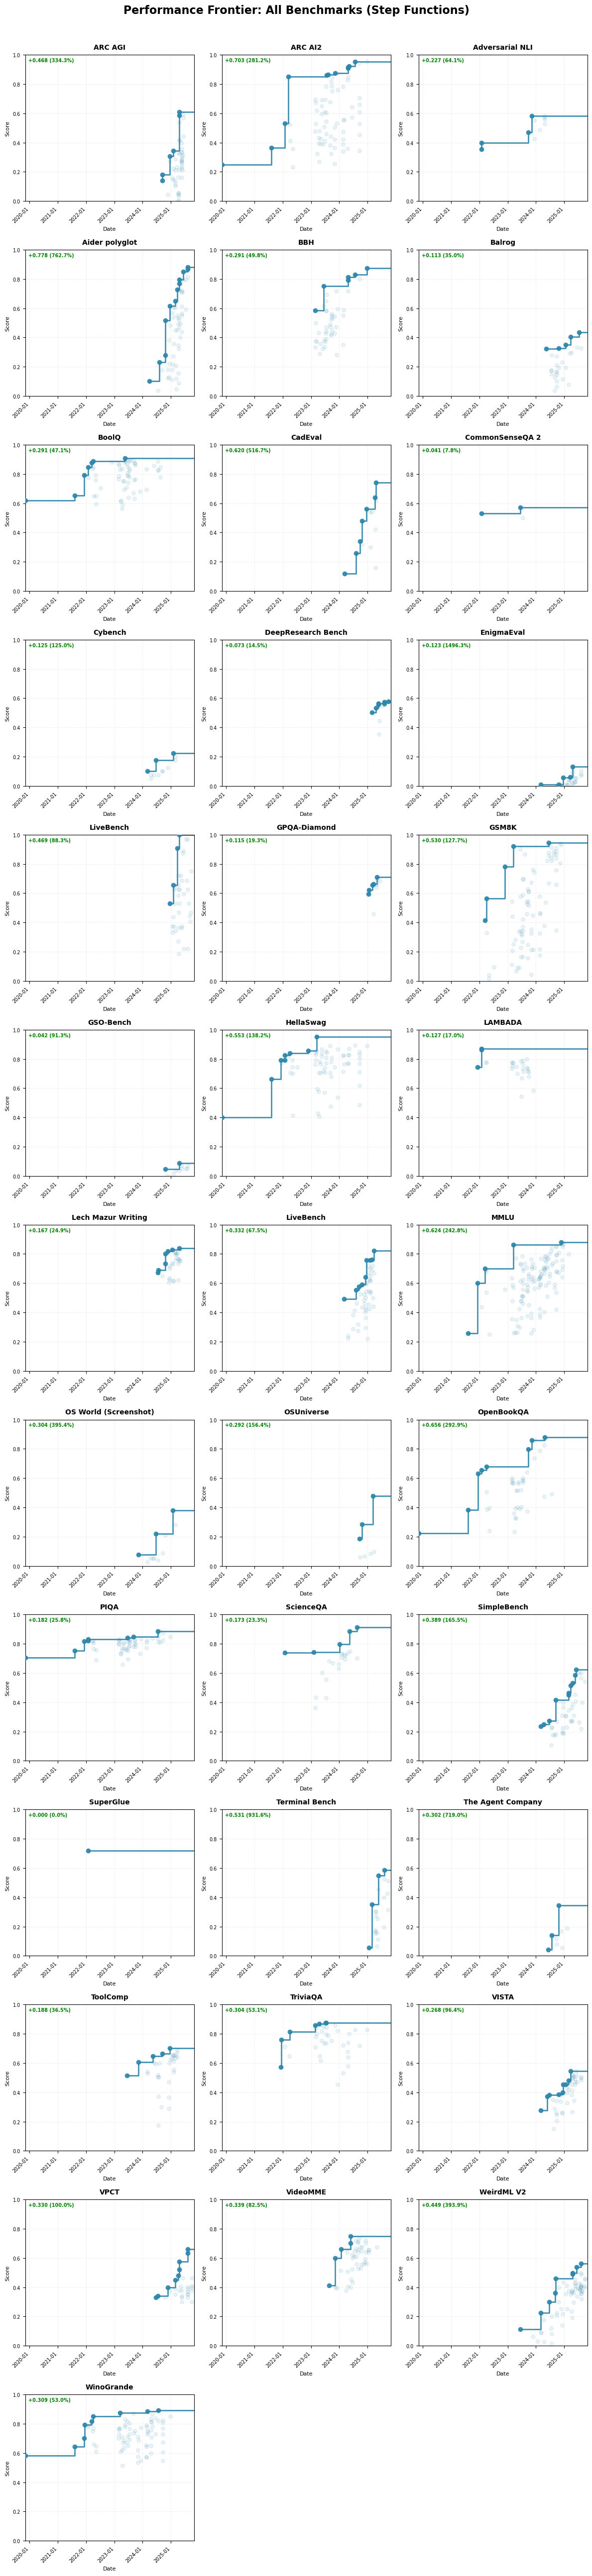


BENCHMARK VISUALIZATION SUMMARY
Benchmarks plotted: 37
Date range: 2019-11-05 to 2025-10-29
Score range: 0.000 to 1.000
Grid: 13 rows × 3 columns


In [36]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

def plot_all_benchmarks_individual_stepwise(benchmark_matrices, exclude_patterns=None, 
                                           figsize=(12, 8), cols=3):
    """
    Plot each benchmark individually with consistent x and y axes.
    Shows all data points (transparent) with step function frontier line on top.
    
    Args:
        benchmark_matrices: dict from extract_benchmark_matrices_from_df
        exclude_patterns: list of strings to exclude (if any task_path contains these)
        figsize: size of each individual figure
        cols: number of columns in the grid layout
    """
    
    if exclude_patterns is None:
        exclude_patterns = []
    
    # Filter out excluded benchmarks
    filtered_items = []
    for task_path, data in sorted(benchmark_matrices.items()):
        should_exclude = any(pattern in task_path for pattern in exclude_patterns)
        if not should_exclude:
            filtered_items.append((task_path, data))
    
    if not filtered_items:
        print("No benchmarks to plot")
        return
    
    # Find global date range and score range across all benchmarks
    all_dates = []
    all_scores = []
    
    for task_path, data in filtered_items:
        df_long = data['df_long']
        if not df_long.empty:
            all_dates.extend(df_long['date'].tolist())
            all_scores.extend(df_long['avg_score'].tolist())
    
    if not all_dates:
        print("No data to plot")
        return
    
    # Determine global ranges
    global_date_min = min(all_dates)
    global_date_max = max(all_dates)
    # Add some padding to show the step after the last data point
    global_date_max = global_date_max + timedelta(days=30)
    
    global_score_min = max(0, min(all_scores) - 0.05)  # Add 5% padding
    global_score_max = min(1, max(all_scores) + 0.05)
    
    # Calculate grid dimensions
    n_benchmarks = len(filtered_items)
    rows = int(np.ceil(n_benchmarks / cols))
    
    # Create figure with subplots
    fig, axes = plt.subplots(rows, cols, figsize=(figsize[0] * cols / 3, figsize[1] * rows / 3))
    
    # Flatten axes array for easier indexing
    if n_benchmarks == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
    
    # Plot each benchmark
    for idx, (task_path, data) in enumerate(filtered_items):
        ax = axes[idx]
        df_long = data['df_long']
        
        if df_long.empty:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', 
                   transform=ax.transAxes, fontsize=12, color='gray')
            ax.set_title(task_path.split('.')[-1], fontsize=10, fontweight='bold')
            continue
        
        # Sort by date
        df_sorted = df_long.sort_values('date')
        
        # Plot all data points (transparent)
        ax.scatter(df_sorted['date'], df_sorted['avg_score'], 
                  s=30, alpha=0.1, color='#2E86AB', zorder=1)
        
        # Calculate frontier (best score over time)
        best_score = float('-inf')
        frontier_improvements = []
        
        for _, row in df_sorted.iterrows():
            if row['avg_score'] > best_score:
                best_score = row['avg_score']
                frontier_improvements.append({
                    'date': row['date'],
                    'score': row['avg_score']
                })
        
        if not frontier_improvements:
            ax.text(0.5, 0.5, 'No frontier', ha='center', va='center', 
                   transform=ax.transAxes, fontsize=12, color='gray')
            continue
        
        # Create step function data
        step_dates = []
        step_scores = []
        
        # Start from the first improvement (not from global_date_min)
        first_improvement = frontier_improvements[0]
        step_dates.append(first_improvement['date'])
        step_scores.append(first_improvement['score'])
        
        for i in range(1, len(frontier_improvements)):
            # Add point just before the improvement (continuing previous score)
            step_dates.append(frontier_improvements[i]['date'])
            step_scores.append(frontier_improvements[i-1]['score'])
            
            # Add the improvement point
            step_dates.append(frontier_improvements[i]['date'])
            step_scores.append(frontier_improvements[i]['score'])
        
        # Extend the last score to the end of the plot
        step_dates.append(global_date_max)
        step_scores.append(frontier_improvements[-1]['score'])
        
        # Plot step function frontier
        ax.plot(step_dates, step_scores, '-', 
                linewidth=2, color='#2E86AB', 
                alpha=0.9, zorder=2, label='Frontier')
        
        # Plot markers at improvement points
        improvement_dates = [imp['date'] for imp in frontier_improvements]
        improvement_scores = [imp['score'] for imp in frontier_improvements]
        ax.plot(improvement_dates, improvement_scores, 'o', 
                markersize=6, color='#2E86AB', 
                alpha=0.9, zorder=3)
        
        # Shorten task name for title
        task_name = task_path.split('.')[-1] if '.' in task_path else task_path
        if len(task_name) > 40:
            task_name = task_name[:37] + '...'
        
        # Set title and labels
        ax.set_title(task_name, fontsize=10, fontweight='bold', pad=8)
        ax.set_xlabel('Date', fontsize=8)
        ax.set_ylabel('Score', fontsize=8)
        
        # Set consistent axis ranges
        ax.set_xlim(global_date_min, global_date_max)
        ax.set_ylim(global_score_min, global_score_max)
        
        # Format x-axis dates
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.xaxis.set_major_locator(mdates.YearLocator())
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=7)
        
        # Format y-axis
        ax.tick_params(axis='y', labelsize=7)
        
        # Grid
        ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
        
        # Add improvement text
        initial_score = frontier_improvements[0]['score']
        final_score = frontier_improvements[-1]['score']
        improvement = final_score - initial_score
        
        if initial_score > 0:
            pct_improvement = (improvement / initial_score) * 100
            ax.text(0.02, 0.98, f'+{improvement:.3f} ({pct_improvement:.1f}%)', 
                   transform=ax.transAxes, fontsize=7, 
                   verticalalignment='top', color='green', fontweight='bold')
        else:
            ax.text(0.02, 0.98, f'+{improvement:.3f}', 
                   transform=ax.transAxes, fontsize=7, 
                   verticalalignment='top', color='green', fontweight='bold')
    
    # Hide unused subplots
    for idx in range(n_benchmarks, len(axes)):
        axes[idx].axis('off')
    
    # Overall title
    fig.suptitle('Performance Frontier: All Benchmarks (Step Functions)', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.show()
    
    # Print summary
    print("\n" + "="*80)
    print("BENCHMARK VISUALIZATION SUMMARY")
    print("="*80)
    print(f"Benchmarks plotted: {n_benchmarks}")
    print(f"Date range: {global_date_min} to {global_date_max}")
    print(f"Score range: {global_score_min:.3f} to {global_score_max:.3f}")
    print(f"Grid: {rows} rows × {cols} columns")

# Plot all external benchmarks with step functions
plot_all_benchmarks_individual_stepwise(
    benchmark_matrices_ext,
    exclude_patterns=[],  # Include all benchmarks
    figsize=(12, 12),
    cols=3  # 3 columns per row
)

# Export

In [37]:
# Export matrices to CSV files
import os
output_dir = "benchmark_matrices_csv"
os.makedirs(output_dir, exist_ok=True)
for source, matrices in [("internal", benchmark_matrices), ("external", benchmark_matrices_ext)]:
    for task_path, data in matrices.items():
        # Prepare filename
        safe_task_name = task_path.replace("/", "_").replace("\\", "_").replace(" ", "_")
        filename = f"{source}_{safe_task_name}_matrix.csv"
        filepath = os.path.join(output_dir, filename)
        
        # Export wide DataFrame to CSV
        data['df_wide'].to_csv(filepath, index_label='date')
        
        print(f"Exported {source} benchmark matrix for '{task_path}' to {filepath}")

Exported internal benchmark matrix for 'bench.task.otis_mock_aime.otis_mock_aime_24_25' to benchmark_matrices_csv/internal_bench.task.otis_mock_aime.otis_mock_aime_24_25_matrix.csv
Exported internal benchmark matrix for 'bench.task.hendrycks_math.hendrycks_math_lvl_5' to benchmark_matrices_csv/internal_bench.task.hendrycks_math.hendrycks_math_lvl_5_matrix.csv
Exported internal benchmark matrix for 'bench.task.frontiermath.frontiermath_tier_4_2025_07_01_private' to benchmark_matrices_csv/internal_bench.task.frontiermath.frontiermath_tier_4_2025_07_01_private_matrix.csv
Exported internal benchmark matrix for 'bench.task.gpqa.gpqa_diamond' to benchmark_matrices_csv/internal_bench.task.gpqa.gpqa_diamond_matrix.csv
Exported internal benchmark matrix for 'bench.task.frontiermath.frontiermath_2025_02_28_public' to benchmark_matrices_csv/internal_bench.task.frontiermath.frontiermath_2025_02_28_public_matrix.csv
Exported internal benchmark matrix for 'bench.task.frontiermath.frontiermath_tier_4